In [1]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

from nflows.flows.base import Flow
from nflows.flows.realnvp import SimpleRealNVP
from nflows.distributions.base import Distribution
from nflows.transforms.base import CompositeTransform
from nflows.transforms.coupling import CouplingTransform, AdditiveCouplingTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

from simple_einet.einet import EinetConfig, Einet
from simple_einet.distributions.normal import RatNormal

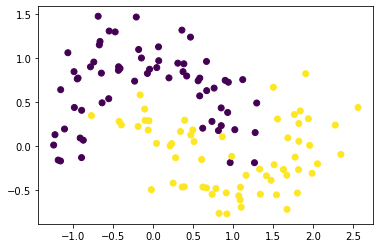

In [2]:
x, y = datasets.make_moons(128, noise=.25)
plt.scatter(x[:, 0], x[:, 1], c=y);

In [9]:
class FlowSpn(Distribution):
    def __init__(self, n_features, n_classes=1, n_resolutions=2):
        super().__init__()
        self.n_features = n_features
        self.n_classes = n_classes
        self.n_resolutions = n_resolutions
        
        spn_cfg = EinetConfig(
            num_features=n_features,
            num_channels=1,
            num_sums=3,
            num_leaves=3,
            num_repetitions=2,
            num_classes=n_classes,
            depth=1,
            leaf_type=RatNormal,
            leaf_kwargs={"min_sigma": 0.0001, "max_sigma": 3.},
        )
        
        flow_spn_cfg = EinetConfig(
            num_features=n_features,
            num_channels=1,
            num_sums=2,
            num_leaves=2,
            num_repetitions=2,
            num_classes=n_classes,
            depth=1,
            leaf_type=RatNormal,
            leaf_kwargs={"min_sigma": 0.1, "max_sigma": 1.},
        )
        

        self.spns = nn.ModuleList([
            Einet(spn_cfg),
            Einet(flow_spn_cfg)
        ])
        
        # mixture of resolutions
        self.last_layer_weights = nn.Parameter(
            torch.rand(self.n_classes, self.n_resolutions, 1)
        )
        
        self.flow_and_standard_ll = None
    
    
    def _log_prob(self, inputs, context, marginalization_mask=None, ldj=0):  
        assert inputs.shape == (inputs.shape[0], self.n_resolutions, self.n_features)
        
        res = list()
        for i, spn in enumerate(self.spns):
            add = torch.tensor([0]).cuda()
            if i > 0:
                add = ldj
            res.append(spn(inputs[:, i, :]) + add.unsqueeze(-1).expand(-1, self.n_classes))
            
        x = torch.stack(res, dim=2)
        
        assert x.shape == (inputs.shape[0], self.n_classes, self.n_resolutions), res.shape
        
        self.flow_and_standard_ll = x
        
        probs_max = torch.max(x, dim=2, keepdim=True)[0]
        probs = torch.exp(x - probs_max)

        weights = self.last_layer_weights
        weights = F.softmax(weights, dim=1)

        out = torch.einsum("ncr,cro->nco", probs, weights)
        ll = torch.log(out) + probs_max
        ll = ll.squeeze(-1)
        assert ll.shape == (inputs.shape[0], self.n_classes)
        return ll 

    def _sample(self, num_samples, context):
        raise NotImplementedError
       

    def _mean(self, context):
        return self.means

In [10]:
num_layers = 4

class MLP(nn.Module):
    """A standard multi-layer perceptron."""

    def __init__(
        self,
        in_shape,
        out_shape,
        hidden_sizes,
        activation=F.relu,
        activate_output=False,
    ):
        """
        Args:
            in_shape: tuple, list or torch.Size, the shape of the input.
            out_shape: tuple, list or torch.Size, the shape of the output.
            hidden_sizes: iterable of ints, the hidden-layer sizes.
            activation: callable, the activation function.
            activate_output: bool, whether to apply the activation to the output.
        """
        super().__init__()
        self._in_shape = torch.Size(in_shape)
        self._out_shape = torch.Size(out_shape)
        self._hidden_sizes = hidden_sizes
        self._activation = activation
        self._activate_output = activate_output

        if len(hidden_sizes) == 0:
            raise ValueError("List of hidden sizes can't be empty.")

        self._input_layer = nn.Linear(np.prod(in_shape), hidden_sizes[0])
        self._hidden_layers = nn.ModuleList(
            [
                nn.Linear(in_size, out_size)
                for in_size, out_size in zip(hidden_sizes[:-1], hidden_sizes[1:])
            ]
        )
        self._output_layer = nn.Linear(hidden_sizes[-1], np.prod(out_shape))

    def forward(self, inputs, context=None):
        if inputs.shape[1:] != self._in_shape:
            raise ValueError(
                "Expected inputs of shape {}, got {}.".format(
                    self._in_shape, inputs.shape[1:]
                )
            )

        inputs = inputs.reshape(-1, np.prod(self._in_shape))
        outputs = self._input_layer(inputs)
        outputs = self._activation(outputs)

        for hidden_layer in self._hidden_layers:
            outputs = hidden_layer(outputs)
            outputs = self._activation(outputs)

        outputs = self._output_layer(outputs)
        if self._activate_output:
            outputs = self._activation(outputs)
        outputs = outputs.reshape(-1, *self._out_shape)

        return outputs


def create_net(in_features, out_features):
    return MLP((in_features,), (out_features,), (5, 3))

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=2))
    transforms.append(
        MaskedAffineAutoregressiveTransform(features=2, 
                                          hidden_features=4, 
                                          context_features=1)
        #AdditiveCouplingTransform(
        #    mask=torch.tensor([0, 1]),
        #    transform_net_create_fn=create_net
        #)
    )
flow = CompositeTransform(transforms).cuda()

In [11]:
flow_spn = FlowSpn(
    2, n_classes=2, n_resolutions=2
).train().cuda()

param_list = [
    {"params": flow_spn.parameters(), "lr":.01},
    {"params": flow.parameters(), "lr":.01}
]
    
optimizer = optim.Adam(param_list)
scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)

tensor(0.2188, device='cuda:0', dtype=torch.float64)
lr 0.0099
ll tensor(-3.7703, device='cuda:0', grad_fn=<MeanBackward0>)
kl tensor(-0.0020, device='cuda:0', grad_fn=<MeanBackward0>)
standard and flow weights tensor([[[0.4931],
         [0.5512]],

        [[0.5069],
         [0.4488]]])


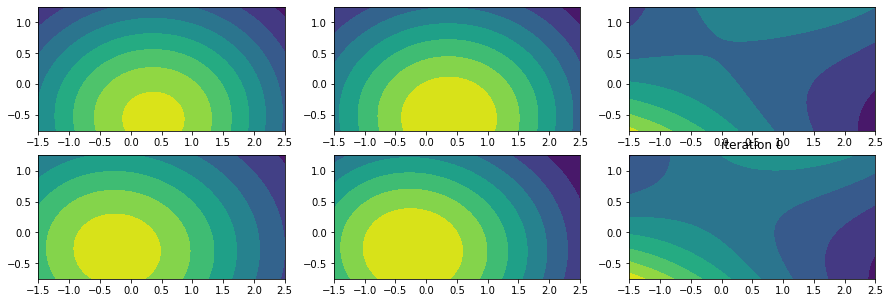

tensor(0.9141, device='cuda:0', dtype=torch.float64)
lr 0.009801
ll tensor(-2.6423, device='cuda:0', grad_fn=<MeanBackward0>)
kl tensor(0.0315, device='cuda:0', grad_fn=<MeanBackward0>)
standard and flow weights tensor([[[0.6999],
         [0.3387]],

        [[0.3001],
         [0.6613]]])


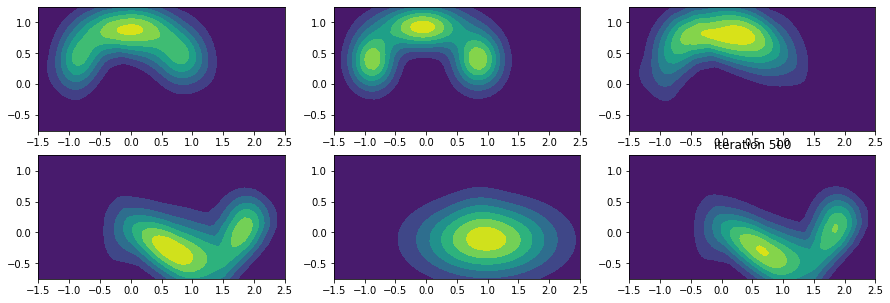

tensor(0.9375, device='cuda:0', dtype=torch.float64)
lr 0.00970299
ll tensor(-2.9956, device='cuda:0', grad_fn=<MeanBackward0>)
kl tensor(0.0120, device='cuda:0', grad_fn=<MeanBackward0>)
standard and flow weights tensor([[[0.8476],
         [0.1768]],

        [[0.1524],
         [0.8232]]])


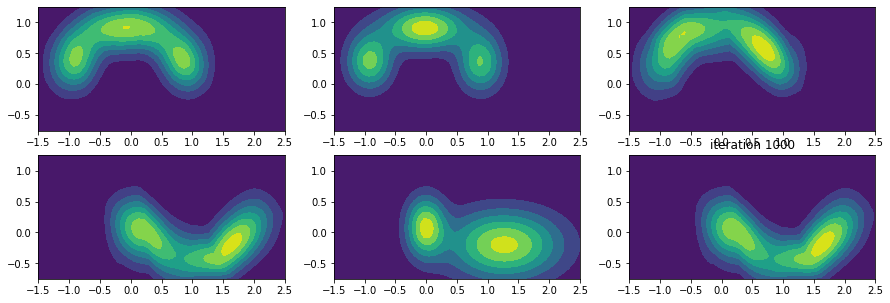

tensor(0.9453, device='cuda:0', dtype=torch.float64)
lr 0.0096059601
ll tensor(-3.2561, device='cuda:0', grad_fn=<MeanBackward0>)
kl tensor(0.0171, device='cuda:0', grad_fn=<MeanBackward0>)
standard and flow weights tensor([[[0.8485],
         [0.1758]],

        [[0.1515],
         [0.8242]]])


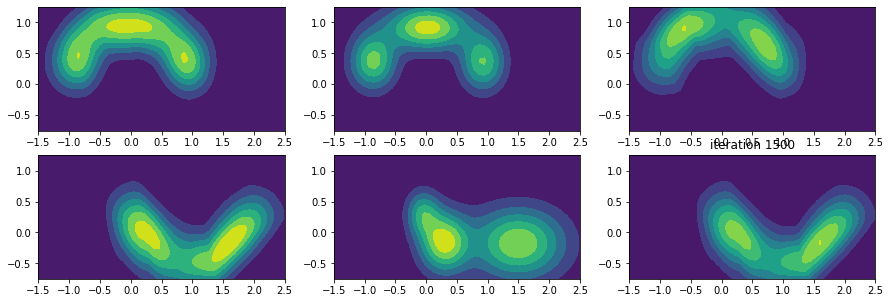

tensor(0.9688, device='cuda:0', dtype=torch.float64)
lr 0.009509900499
ll tensor(-3.2164, device='cuda:0', grad_fn=<MeanBackward0>)
kl tensor(0.0050, device='cuda:0', grad_fn=<MeanBackward0>)
standard and flow weights tensor([[[0.7136],
         [0.3241]],

        [[0.2864],
         [0.6759]]])


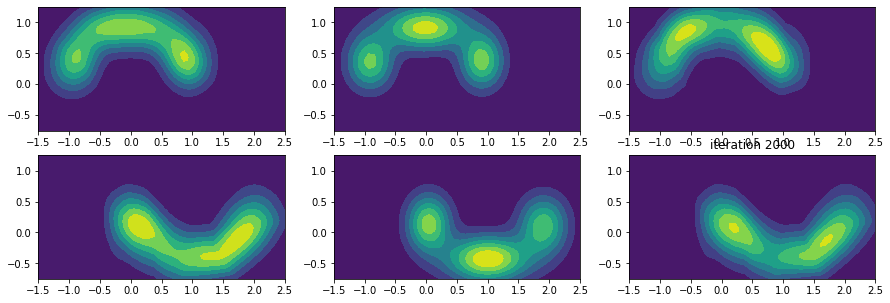

tensor(0.9141, device='cuda:0', dtype=torch.float64)
lr 0.00941480149401
ll tensor(-3.2595, device='cuda:0', grad_fn=<MeanBackward0>)
kl tensor(0.0033, device='cuda:0', grad_fn=<MeanBackward0>)
standard and flow weights tensor([[[0.5105],
         [0.5340]],

        [[0.4895],
         [0.4660]]])


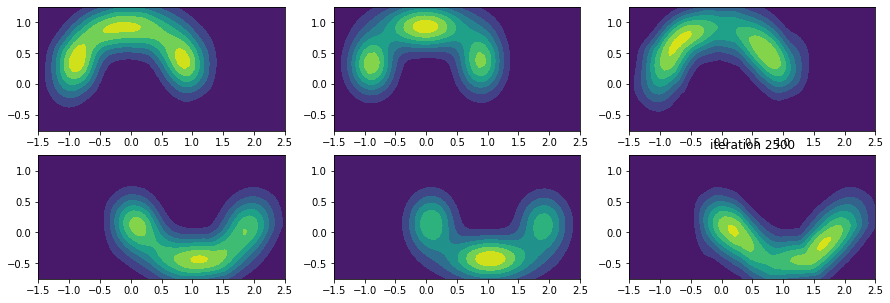

tensor(0.9141, device='cuda:0', dtype=torch.float64)
lr 0.0093206534790699
ll tensor(-3.4565, device='cuda:0', grad_fn=<MeanBackward0>)
kl tensor(0.0170, device='cuda:0', grad_fn=<MeanBackward0>)
standard and flow weights tensor([[[0.4743],
         [0.5698]],

        [[0.5257],
         [0.4302]]])


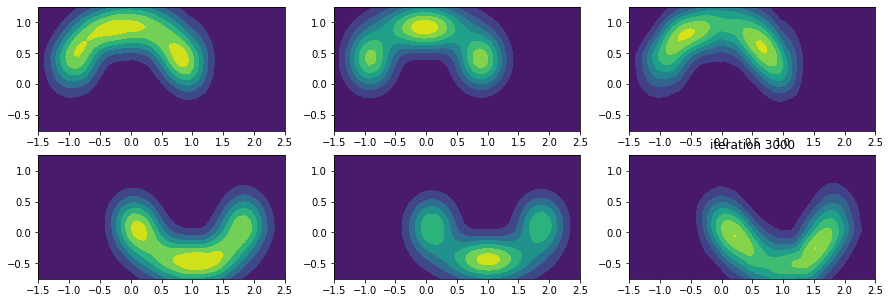

In [12]:
batch_size = 128
num_iter = 3000
alpha = 0.9


def train_batch(x, y, alpha):
    x = torch.tensor(x, dtype=torch.float32).cuda()
    z, ldj = flow(x)
    xz = torch.stack((x, z), dim=1) # shape = (batch, resolution, features)
    y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1).cuda()
    
    optimizer.zero_grad()
    
    ll = flow_spn._log_prob(inputs=xz, context=y, ldj=ldj)
    cross_entropy_last = ll.gather(dim=1, index=y.to(int)).mean()
    cross_entropy_prev = flow_spn.flow_and_standard_ll.gather(dim=1, index=y.unsqueeze(-1).repeat(1, 1, 2).to(int)).mean()

    
    loss = - alpha * cross_entropy_prev - (1 - alpha) * cross_entropy_last
    
    loss.backward()
    optimizer.step()
    return ll

def show(ll, y):
    y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1).cuda()
    grid_units = 50
    acc = (ll.argmax(dim=1, keepdims=True) == y).to(float).mean()
    print(acc)
    print("lr", optimizer.param_groups[0]["lr"])
    print("ll", ll.mean())
    kl = F.kl_div(flow_spn.flow_and_standard_ll[:,:,0], flow_spn.flow_and_standard_ll[:,:,1].exp())
    print("kl", kl)
    print("standard and flow weights", F.softmax(flow_spn.last_layer_weights, dim=0).cpu().detach())

    fig, ax = plt.subplots(2, 3, figsize=(15, 5))
    xline = torch.linspace(-1.5, 2.5, grid_units)
    yline = torch.linspace(-.75, 1.25, grid_units)
    xgrid, ygrid = torch.meshgrid(xline, yline)
    xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1).cuda()
    with torch.no_grad():
        z, ldj = flow(xyinput)
        xyinput = torch.stack((xyinput, z), dim=1)
        zgrid = flow_spn._log_prob(xyinput, context=y, ldj=ldj).exp()
        class_one = zgrid[:, 0].reshape(grid_units, grid_units)
        class_two = zgrid[:, 1].reshape(grid_units, grid_units)
        zgrid1_class_one = flow_spn.flow_and_standard_ll[:,0,0].exp().reshape(grid_units, grid_units)
        zgrid1_class_two = flow_spn.flow_and_standard_ll[:,1,0].exp().reshape(grid_units, grid_units)
        zgrid2_class_one = flow_spn.flow_and_standard_ll[:,0,1].exp().reshape(grid_units, grid_units)
        zgrid2_class_two = flow_spn.flow_and_standard_ll[:,1,1].exp().reshape(grid_units, grid_units)

    # last mixture
    ax[0,0].contourf(xgrid.numpy(), ygrid.numpy(), class_one.cpu().detach().numpy())
    ax[1,0].contourf(xgrid.numpy(), ygrid.numpy(), class_two.cpu().detach().numpy())

    # spn
    ax[0,1].contourf(xgrid.numpy(), ygrid.numpy(), zgrid1_class_one.cpu().detach().numpy())
    ax[1,1].contourf(xgrid.numpy(), ygrid.numpy(), zgrid1_class_two.cpu().detach().numpy())

    # flow spn
    ax[0,2].contourf(xgrid.numpy(), ygrid.numpy(), zgrid2_class_one.cpu().detach().numpy())
    ax[1,2].contourf(xgrid.numpy(), ygrid.numpy(), zgrid2_class_two.cpu().detach().numpy())
    plt.title('iteration {}'.format(i))
    plt.show()


for i in range(num_iter + 1):
    x, y = datasets.make_moons(batch_size, noise=.25)
    if i == num_iter and False:
        alpha = 0.5
    ll = train_batch(x, y, alpha)
    
    if i %  500 == 0:
        scheduler.step()
        show(ll, y)